# Supervised Learning - Classification

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import wandb

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
# Define the split ratio
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset into training and validation sets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [9]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = FashionMNISTModel()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

In [11]:
wandb.init(project="mldevops_exercise", config={
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 32
})

Training Loss,█▂▁▁▁▁▁▁▁▁▁▁
Validation Loss,▂▃█▂▇▄▂▇▂▃▄▁
Training Loss,0.41356
Validation Loss,0.40748


In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        training_loss = running_loss / len(train_loader)

        # Validation Loop
        model.eval()  # Set model to evaluation mode
        validation_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
        
        # Calculate average validation loss
        validation_loss /= len(val_loader)        
        
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")
        
        wandb.log({"Training Loss": training_loss, "Validation Loss": validation_loss})


train(model, train_loader, val_loader, criterion, optimizer, epochs=30)

Epoch [1/30], Training Loss: 2.8071, Validation Loss: 0.7681
Epoch [2/30], Training Loss: 0.5436, Validation Loss: 0.4744
Epoch [3/30], Training Loss: 0.4767, Validation Loss: 0.5511
Epoch [4/30], Training Loss: 0.4732, Validation Loss: 0.4573
Epoch [5/30], Training Loss: 0.4429, Validation Loss: 0.4675
Epoch [6/30], Training Loss: 0.4473, Validation Loss: 0.4900
Epoch [7/30], Training Loss: 0.4456, Validation Loss: 0.5001
Epoch [8/30], Training Loss: 0.4229, Validation Loss: 0.5236
Epoch [9/30], Training Loss: 0.4265, Validation Loss: 0.5423
Epoch [10/30], Training Loss: 0.4267, Validation Loss: 0.5598
Epoch [11/30], Training Loss: 0.4196, Validation Loss: 0.4884
Epoch [12/30], Training Loss: 0.4194, Validation Loss: 0.4937
Epoch [13/30], Training Loss: 0.4147, Validation Loss: 0.5851
Epoch [14/30], Training Loss: 0.4140, Validation Loss: 0.5046
Epoch [15/30], Training Loss: 0.4004, Validation Loss: 0.4990
Epoch [16/30], Training Loss: 0.4059, Validation Loss: 0.7182
Epoch [17/30], Tr

In [13]:
artifact = wandb.Artifact("project_code", type="code")
artifact.add_file("Supervised_Learning_Classification.ipynb")  # Add your script files
wandb.log_artifact(artifact)

<Artifact project_code>

In [14]:
wandb.finish()

Training Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▁▃▁▁▂▂▂▃▃▂▂▄▂▂▇▂▃▂▆▂█▅▄▇▅▄▅▆▄
Training Loss,0.39182
Validation Loss,0.57632


In [15]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.2f}%")


test(model, test_loader, criterion)

Test Loss: 0.5340, Accuracy: 85.27%


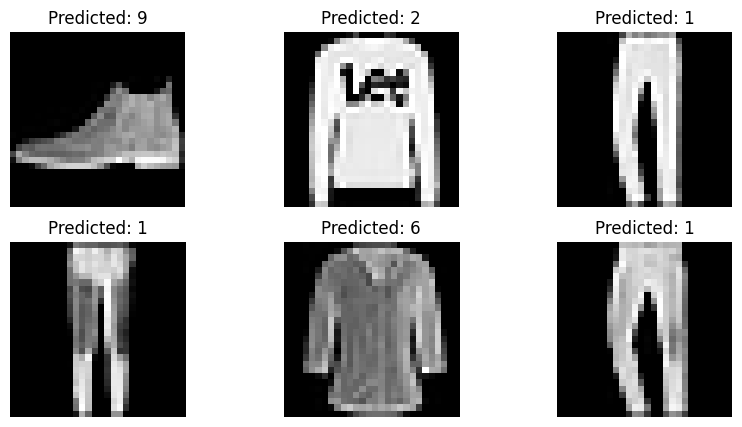

In [16]:
def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(f"Predicted: {preds[i].item()}")
        plt.axis("off")
    plt.show()


visualize_predictions(model, test_loader)